## 1. Setup
First, you must clone the `ssm` repository and install all of the dependencies. The `ssm` package we are using can be found, along with installation instructions, [here](https://github.com/lindermanlab/ssm.git). 

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [2]:
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sglm import hmmUtils, utils
import ssm

npr.seed(42)

#### 1a. Import your data

In [3]:
data_ = pd.read_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FreelyMoving_6nback_102323_wDOB_wrecordDF.csv')

C:\Users\janet\AppData\Local\Temp\ipykernel_8880\1526347576.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ = pd.read_csv(r'C:\Users\janet\Documents\Behavior_samp_data\FreelyMoving_6nback_102323_wDOB_wrecordDF.csv')


In [4]:
probs = '80-20'
ages = [1, 2, 3, 4] # 1: 2 months, 2: 4 months, 3: 6 months, 4: 12 months
trial_based = 1
filtered_data = data_[(data_['Condition'] == probs) & (data_['Age_Group'].isin(ages)) & (data_['Trial_based'] == trial_based)]

In [5]:
#choice as -1 or 1
filtered_data.loc[:, '1_Port'] = filtered_data['1_Port'].replace(0, -1)
filtered_data.loc[:, '2_Port'] = filtered_data['2_Port'].replace(0, -1)
filtered_data.loc[:, '3_Port'] = filtered_data['3_Port'].replace(0, -1)

In [6]:
#add columns for interaction between reward and choice
filtered_data.loc[:, '1_ChoiceReward'] = filtered_data['1_Port'] * filtered_data['1_Reward']
filtered_data.loc[:, '2_ChoiceReward'] = filtered_data['2_Port'] * filtered_data['2_Reward']
filtered_data.loc[:, '3_ChoiceReward'] = filtered_data['3_Port'] * filtered_data['3_Reward']

C:\Users\janet\AppData\Local\Temp\ipykernel_8880\1374730130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, '1_ChoiceReward'] = filtered_data['1_Port'] * filtered_data['1_Reward']
C:\Users\janet\AppData\Local\Temp\ipykernel_8880\1374730130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, '2_ChoiceReward'] = filtered_data['2_Port'] * filtered_data['2_Reward']
C:\Users\janet\AppData\Local\Temp\ipykernel_8880\1374730130.py:4: SettingWithCopyWarning: 
A value is 

In [7]:
#add up animals in unique age groups
age_group = filtered_data.groupby('Age_Group')

#add up in each age group
age_group_counts = age_group['Mouse ID'].unique()
age_group_counts = age_group_counts.apply(lambda x: len(x))
age_group_counts

Age_Group
1.0    12
2.0     8
3.0    11
4.0     8
Name: Mouse ID, dtype: int64

## 2. Input Driven Observations
We create a HMM with input-driven observations and 'standard' (stationary) transitions with the following line:  
```python
        ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", observation_kwargs=dict(C=num_categories), transitions="standard")
```

As in Ashwood et al. (2020), we are going to model an animal's binary choice data during a decision-making task, so we will set `num_categories=2` because the animal only has two options available to it. We will also set `obs_dim = 1` because the dimensionality of the observation data is 1 (if we were also modeling, for example, the binned reaction time of the animal, we could set `obs_dim = 2`).  For the sake of simplicity, we will assume that an animal's choice in a particular state is only affected by the external stimulus associated with that particular trial, and its innate choice bias. Thus, we will set `input_dim = 2` and we will simulate input data that resembles sequences of stimuli in what follows.  In Ashwood et al. (2020), they found that many mice used 3 decision-making states when performing 2AFC tasks. We will, thus, set `num_states = 3`.

## 2a. Set up your model and initialize parameters

In [9]:
# Model Inputs
num_states = [4] # number of discrete states, can be a single value or list
obs_dim =  1 # number of observed dimensions, 1 for just reward, 2 if you had something like reaction time
num_categories = 2 # number of categories for the output

# set sigma and alpha for the prior on the weights, set kappa for "sticky" transitions
prior_sigma = 2
prior_alpha = 2
#kappa = 0

### 2b. Option 1 - Data and param set up for global fitting

In [10]:
probs = '80-20'
train_split = 0.90
seed = np.random.randint(1000)

# Get train/test session IDs

train_ids, test_ids = train_test_split(filtered_data['Session ID'].unique(), 
                                      train_size=train_split, random_state=seed)

print('You have {} training sessions and {} test sessions.'.format(len(train_ids), len(test_ids)))

You have 322 training sessions and 36 test sessions.


In [11]:
# Create new dataframes for train/test data

train_data = filtered_data[filtered_data['Session ID'].isin(train_ids)]
test_data = filtered_data[filtered_data['Session ID'].isin(test_ids)]

In [12]:
# Extracting specific columns and creating variables for model input GLOBAL
x_cols = ['1_Reward', '2_Reward', '3_Reward', '1_Port', '2_Port', '3_Port', '1_ChoiceReward', '2_ChoiceReward', '3_ChoiceReward']

#columns for x and y data
train_data_x = train_data[x_cols]
test_data_x = test_data[x_cols]

#number of sessions and trials
train_data_sessions = len(train_data_x)
test_data_sessions = len(test_data_x)

train_num_sess = len(train_data['Session ID'].unique())
test_num_sess = len(test_data['Session ID'].unique())

num_trials_per_train_sess = train_data_sessions
num_trials_per_test_sess = test_data_sessions

# Data inputs 
choices = train_data['Decision'].to_numpy()
choices = choices.reshape(-1, 1)
choices = choices.astype(int)


### 2c. (Option 1) - Fit the model globally with cross validation 

In [13]:
observations = "input_driven_obs"
transitions = "standard"
iters = 500

global_model_list, global_ll_list, global_train_scores, global_test_scores = hmmUtils.global_fit(
    train_data_x, choices, num_states, obs_dim, observations, num_categories, prior_sigma, transitions, prior_alpha, iters)


  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
global_weights = global_model_list[0].observations.params

In [15]:
#save stationary model list, train and test scores, and LL list
import pickle

model_params = {'num_states': num_states,
                'obs_dim': obs_dim,
                'num_categories': num_categories,
                'prior_sigma': prior_sigma,
                'prior_alpha': prior_alpha,
                'observations': observations,
                'transitions': transitions,
                'x_cols': x_cols,
                'data_filter': 'age_group:1-4, probs:80-20, trial_based:1',
                'notes': "used 3 nback data, 80-20 prob, 90-10 split, reward is 0-1, choice is -1-1, global fit"}

data_splits = {'train_split': train_split,
               'train_ids': train_ids,
               'test_ids': test_ids,
               }

#create dictionary for pickle
model_dict = {'model_params' : model_params,
                'data_splits': data_splits,
                   'model_list': global_model_list,
                   'model_train_scores': global_train_scores,
                   'model_test_scores': global_test_scores,
                   'model_ll_list': global_ll_list, 
                   'model_weights': global_weights}

#save dictionary in pickle file
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data\models'
pickle.dump(model_dict, open(os.path.join(save_dir, 'global_fit_' + f'{num_states}state.pkl'), 'wb'))



### 2d. Option 2 - Data and param set up for individual fits 

In [16]:
#create separate datasets for each mouse
mice = filtered_data['Mouse ID'].unique()

mouse_dfs = []

for mouse in mice:
    mouse_data = filtered_data[filtered_data['Mouse ID'] == mouse]
    mouse_dfs.append({'mouse': mouse, 'data': mouse_data})    


In [17]:
#split each mouse's data into train and test sets
train_split = 0.9
seed = np.random.randint(1000)

#get train and test session IDs
train_ids = []
test_ids = []
splits = []

for mouse in mouse_dfs:
    mouse_train, mouse_test = train_test_split(mouse['data']['Session ID'].unique(), 
                                               train_size=train_split, random_state=seed)
    train_ids.append(mouse_train)
    test_ids.append(mouse_test)
    splits.append({'mouse': mouse['mouse'], 'train': len(mouse_train), 'test': len(mouse_test)})

#split data
train_data = []
test_data = []

for i, mouse in enumerate(mouse_dfs):
    train_data.append({'mouse': mouse, 'data': mouse['data'][mouse['data']['Session ID'].isin(train_ids[i])]})
    test_data.append({'mouse': mouse, 'data': mouse['data'][mouse['data']['Session ID'].isin(test_ids[i])]})
        

In [18]:
#looping through each mouse to extract data and set model inputs - INDIVIDUAL
x_cols = ['1_Reward', '2_Reward', '3_Reward', '1_Port', '2_Port', '3_Port', '1_ChoiceReward', '2_ChoiceReward', '3_ChoiceReward']

#create lists of inputs for each mouse 
train_data_x = []
test_data_x = []
train_data_trials_mouse = []
test_data_trials_mouse = []
train_choices = []
test_choices = []

for i, mouse in enumerate(mouse_dfs):
    train_data_x.append({'mouse': train_data[i]['mouse']['mouse'], 'data': train_data[i]['data'][x_cols]})
    test_data_x.append({'mouse': test_data[i]['mouse']['mouse'], 'data': test_data[i]['data'][x_cols]})
    train_data_trials_mouse.append({'mouse': train_data[i]['mouse']['mouse'], 'sessions': len(train_data[i]['data'])})
    test_data_trials_mouse.append({'mouse': test_data[i]['mouse']['mouse'], 'sessions': len(test_data[i]['data'])})
    train_choices.append({'mouse': train_data[i]['mouse']['mouse'], 'choices': train_data[i]['data']['Decision'].to_numpy().reshape(-1, 1).astype(int)})
    test_choices.append({'mouse': test_data[i]['mouse']['mouse'], 'choices': test_data[i]['data']['Decision'].to_numpy().reshape(-1, 1).astype(int)})



### 2e. Option 2 - Fit the model across individual animals with cross validation 

In [19]:
observations = "input_driven_obs"
transitions = "standard"
iters = 500

mouse_model_list, mouse_ll_list, mouse_train_scores, mouse_test_scores = hmmUtils.animal_fit(
    train_data_x, train_choices, num_states, obs_dim, observations, num_categories, prior_sigma, transitions, prior_alpha, iters)

Fitting model for mouse 1/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 2/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 3/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 4/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 5/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 6/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 7/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 8/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 9/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 10/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 11/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 12/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 13/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 14/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 15/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 16/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 17/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 18/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 19/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 20/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 21/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 22/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 23/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 24/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 25/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 26/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 27/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 28/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 29/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 30/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 31/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 32/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 33/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 34/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 35/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 36/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 37/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 38/39...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting model for mouse 39/39...


  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
## loop through each mouse and find generative weights and append to list
mouse_weights = []
for i in range(len(mouse_model_list)):
    mouse_weights.append({'mouse': train_data_x[i]['mouse'], 'weights': mouse_model_list[i]['glmhmm'].observations.params})

In [21]:
#save stationary model list, train and test scores, and LL list
import pickle

model_params = {'num_states': num_states,
                'obs_dim': obs_dim,
                'num_categories': num_categories,
                'prior_sigma': prior_sigma,
                'prior_alpha': prior_alpha,
                'observations': observations,
                'transitions': transitions,
                'x_cols': x_cols,
                'data_filter': 'age_group:1-4, probs:80-20, trial_based:1',
                'notes': "used 3 nback data, 80-20 prob, 90-10 split, reward is 0-1, choice is -1-1, animal fits"}

data_splits = {'train_split': train_split,
               'train_ids': train_ids,
               'test_ids': test_ids,
               'splits': splits}

#create dictionary for pickle
model_dict = {'model_params' : model_params,
                'data_splits': data_splits,
                   'model_list': mouse_model_list,
                   'model_train_scores': mouse_train_scores,
                   'model_test_scores': mouse_test_scores,
                   'model_ll_list': mouse_ll_list, 
                   'weights': mouse_weights}

#save dictionary in pickle file
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data\models'
pickle.dump(model_dict, open(os.path.join(save_dir, 'animal_fits_'+f'{num_states}state.pkl'), 'wb'))



## 3. Plot the results - here, we will plot the GLM weights for the global fit and the individual fits

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


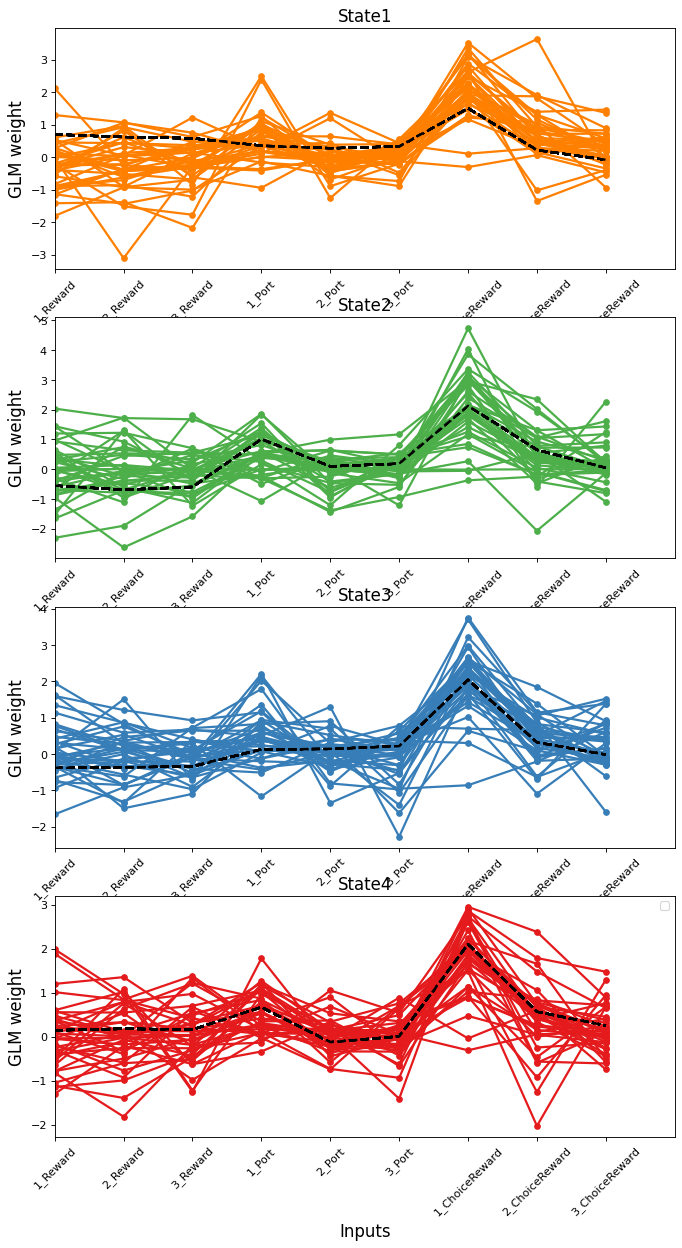

In [26]:
num_states_2plot = 4

cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c']

if num_states_2plot == 1:
    # Plot the GLM weights for each input regressor for each mouse 
    fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
    for i in range(len(mouse_weights)):
        for j in range(num_states_2plot):
            plt.plot(-mouse_weights[i]['weights'][j,0,:], lw=2,
                color=cols[j], marker = 'o', markersize = 5)
            plt.plot(-global_weights[j,0,:], lw=2, color='black', linestyle='--')
    plt.legend(loc="upper right")
    plt.xticks(np.arange(len(x_cols)), x_cols, rotation=45, fontsize = 10)
    plt.ylabel("GLM weight", fontsize = 15)
    plt.xlabel("Inputs", fontsize = 15)
    plt.xlim((0, len(x_cols)))
    plt.title('HMM fits - ' + f'{num_states_2plot}' + 'state')
else:
    ## Plot the GLM weights for each input regressor for each mouse use subplots for each state
    fig, axs = plt.subplots(num_states_2plot, 1, figsize=(10, 18), dpi=80, facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(len(mouse_weights)):
        for j in range(num_states_2plot):
            axs[j].plot(-mouse_weights[i]['weights'][j,0,:], lw=2,
                color=cols[j], marker = 'o', markersize = 5)
            axs[j].plot(-global_weights[j,0,:], lw=2, color='black', linestyle='--')
            axs[j].set_title('State' + str(j + 1), fontsize = 15)
            axs[j].set_ylabel("GLM weight", fontsize = 15)
            axs[j].set_xlabel("Inputs", fontsize = 15)
            axs[j].set_xlim((0, len(x_cols)))
            axs[j].set_xticks(np.arange(len(x_cols)))
            axs[j].set_xticklabels(x_cols, rotation=45, fontsize = 10)
    plt.legend(loc="upper right")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'HMM fits - 4state')

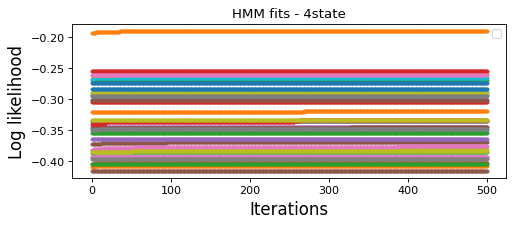

In [23]:
#normalize log likelihoods by number of trials
norm_mouse_ll_list = []
for i, mouse in enumerate(mouse_ll_list):
    sessions = train_data_trials_mouse[i]['sessions']  # Convert to float if necessary
    norm_ll = [k / sessions for k in mouse_ll_list[i]['ll'] if k is not None]
    norm_mouse_ll_list.append({'mouse': train_data_x[i]['mouse'], 'nll': norm_ll})

## Plot the log likelihoods for each mouse
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(norm_mouse_ll_list)):
    plt.plot(norm_mouse_ll_list[i]['nll'], marker = '.', markersize = 5, linestyle = 'None')
plt.legend(loc="upper right")
plt.ylabel("Log likelihood", fontsize = 15)
plt.xlabel("Iterations", fontsize = 15)
plt.title('HMM fits - ' + f'{num_states_2plot}' + 'state')

## Now that we have trained the models, we will compare them with some QC metrics and plot the results.

In [34]:
## Load previously saved model
save_dir = r'C:\Users\janet\Documents\Behavior_samp_data\models'

global_model_1 = pickle.load(open(os.path.join(save_dir, '1-state', 'global_fit_[1]state.pkl'), 'rb'))
global_model_2 = pickle.load(open(os.path.join(save_dir, '2-state', 'global_fit_[2]state.pkl'), 'rb'))
global_model_3 = pickle.load(open(os.path.join(save_dir, '3-state', 'global_fit_[3]state.pkl'), 'rb'))
global_model_4 = pickle.load(open(os.path.join(save_dir, '4-state', 'global_fit_[4]state.pkl'), 'rb'))